<a href="https://colab.research.google.com/github/NhatLeBar/Brain-Tumor-in-MRI-Segmentation-using-U-net/blob/main/Copy_of_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import scipy.misc
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras
from tensorflow.keras.models import load_model

In [ ]:
SEED = 909
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32 #number of images per batch

IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = '/content/drive/MyDrive/MRI/'
data_dir_train = os.path.join(data_dir, 'trainingData/out')
# The images should be stored under: "MRI/trainingData/out/img/img_y"
data_dir_train_image = os.path.join(data_dir_train, 'img')
# The images should be stored under: "MRI/trainingData/out/mask/mask"
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'testingData/out')
# The images should be stored under: "MRI/testingData/out/img/img_y"
data_dir_test_image = os.path.join(data_dir_test, 'img')
# The images should be stored under: "MRI/testingData/out/mask/mask"
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 500
NUM_TEST = 100

NUM_OF_EPOCHS = 25

In [ ]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, 
    class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, 
    class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, 
    class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, 
    class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [ ]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [ ]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        rotated_img = ndimage.rotate(tf.keras.preprocessing.image.array_to_img(display_list[i]), 90)
        plt.imshow(rotated_img, cmap='gray')
    plt.show()


In [ ]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

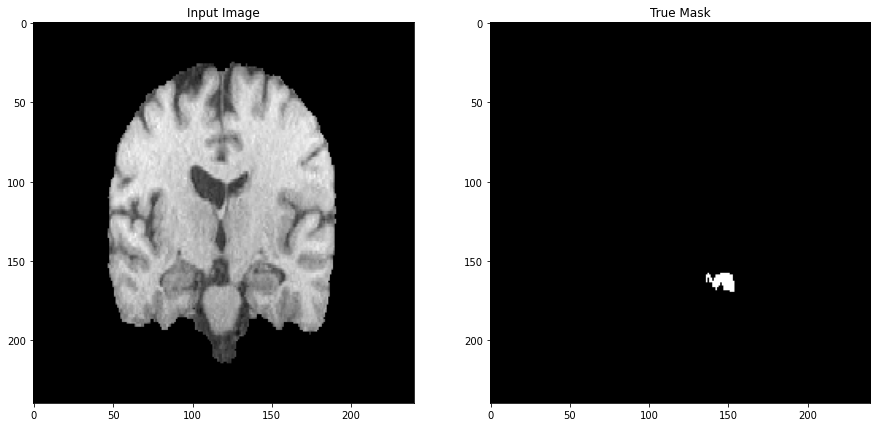

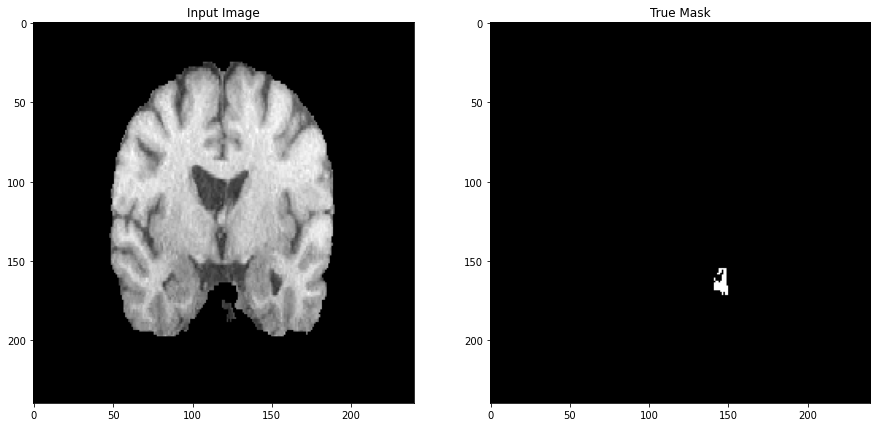

In [ ]:
show_dataset(test_generator, 2)

In [ ]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1): 
    # (no. levels in unet, no. of components in the initial feature vector, no. of convolutions in each level, kernel size, pooling size, in, out)
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels)) 
    # since the images have already been set to gray scale, no. of channels is 1
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same') # used in every conv layer
    
    #downstream
    skips = {} # skip connection saved in a dict
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            # **kwargs == keyword arbitrary arg. == **convpars; (x) is the input tensor for this operation
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [ ]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
ckpt_path = "/content/drive/MyDrive/MRI/Model/model_t2/cp-0025.ckpt"
model.load_weights(ckpt_path)

In [ ]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 240, 240, 32  9248        ['conv2d[0][0]']                 
                                )                                                       

In [ ]:
from gc import callbacks
#include the epoch in the file name
checkpoint_path = "/content/drive/MyDrive/MRI/Model/model_t2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#create callback which saves the model's weights every epoch    
cp_callback = tf.keras.callbacks.ModelCheckpoint(
              filepath=checkpoint_path,
              save_weights_only=True,
              verbose=1)


model.fit_generator(generator=train_generator, 
          steps_per_epoch=EPOCH_STEP_TRAIN, 
          validation_data=test_generator,   
          validation_steps=EPOCH_STEP_TEST,
          epochs=NUM_OF_EPOCHS,
          callbacks=[cp_callback])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9787 
Epoch 1: saving model to /content/drive/MyDrive/MRI/Model/model_t1/cp-0001.ckpt
31/31 [==============================] - 1445s 47s/step - loss: 0.0067 - accuracy: 0.9787 - val_loss: 0.0442 - val_accuracy: 0.9844
Epoch 2/10
31/31 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9788 
Epoch 2: saving model to /content/drive/MyDrive/MRI/Model/model_t1/cp-0002.ckpt
31/31 [==============================] - 1403s 46s/step - loss: 0.0070 - accuracy: 0.9788 - val_loss: 0.0362 - val_accuracy: 0.9835
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9789 
Epoch 3: saving model to /content/drive/MyDrive/MRI/Model/model_t1/cp-0003.ckpt
31/31 [==============================] - 1438s 46s/step - loss: 0.0064 - accuracy: 0.9789 - val_loss: 0.0375 - val_accuracy: 0.9842
Epoch 4/10
31/31 [==============================] - ETA: 0s - loss: 0.0060 - ac

In [ ]:
model.save(f'/content/drive/MyDrive/MRI/model_t2/UNET-BrainSegmentation_{IMAGE_HEIGHT}_{IMAGE_WIDTH}_1.h5')

In [ ]:
from tensorflow.keras.models import load_model
load_path = '/content/drive/MyDrive/MRI/model/'
model = load_model(os.path.join(load_path, 'UNET-BrainSegmentation_240_240_1.h5'))

In [ ]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [ ]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        np.save(os.path.join(load_path,f'img_{i}.npy'),image[0])
        np.save(os.path.join(load_path,f'msk_{i}.npy'),mask[0])
        np.save(os.path.join(load_path,f'pred_{i}.npy'),pred_mask)
        display([image[0], mask[0], pred_mask]) 

In [ ]:
def evaluation(mask, pred_mask):
 truePositive = 0    #do have tumors and detected as having tumors
 trueNegative = 0    #dont have tumors and detected as not having tumors
 falsePositive = 0   #dont have tumors but detected as having tumors
 falseNegative = 0   #have tumors but detected as not having tumors

 for i in range(0, len(mask)):
    for j in range(0, len(mask)):
        if pred_mask[i][j]:
          case1 = pred_mask[i][j] - mask[i][j]
          if case1 < 0.1:
            truePositive = truePositive + 1
          else:
            falsePositive = falsePositive + 1

        else: 
          case0 = mask[i][j] - pred_mask[i][j]
          if case0 == 0:
            trueNegative = trueNegative + 1
          else:
            falseNegative = falseNegative + 1              
  
 accuracy = ((truePositive + trueNegative)/ ((len(mask))*(len(mask))))*100

 if truePositive != 0 or falseNegative != 0:
    sensitivity = (truePositive/(truePositive + falseNegative))*100
 else:
    sensitivity = 0

 specificity = (trueNegative/(falsePositive + trueNegative))*100
  
 return accuracy, sensitivity, specificity  

In [ ]:
def print_evaluation(acc, sen, spec, mask, pred):
  for i in range(0, SHOW_NUM):
    acc[i], sen[i], spec[i] = evaluation(mask[i], pred[i])
    print('The evaluation of prediction', i+1, 'is as follows:', 
          ' accuracy=', acc[i], ' sensitivity=', sen[i],
          ' specificity=', spec[i])

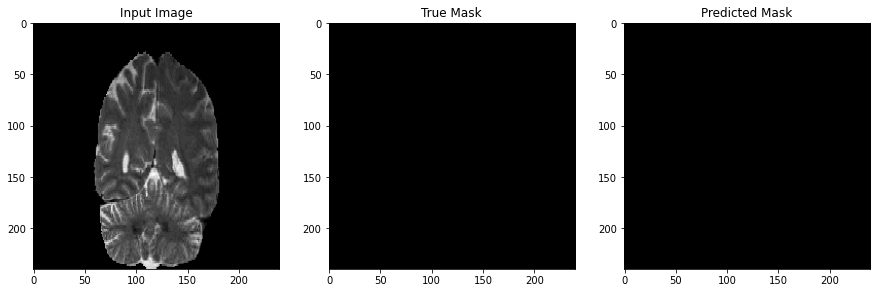

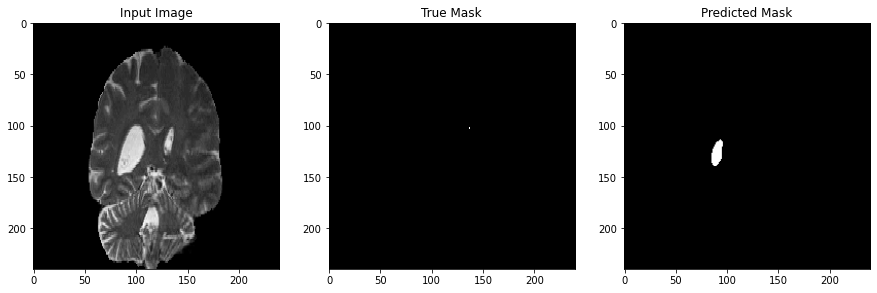

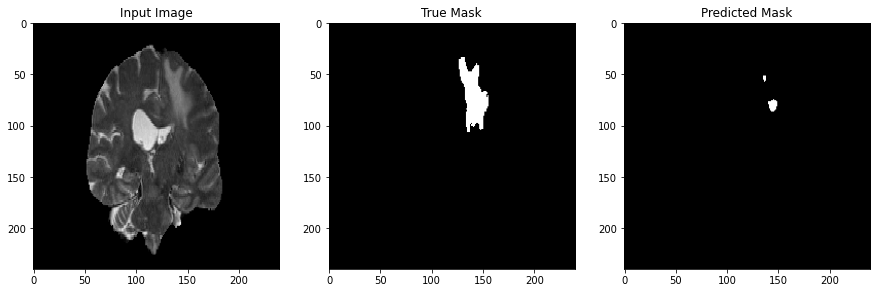

In [ ]:
SHOW_NUM = 3
show_prediction(test_generator, SHOW_NUM)

In [ ]:
acc_a = 0
acc_b = 0
acc_c = 0
acc = [acc_a, acc_b, acc_c]

sen_a = 0
sen_b = 0
sen_c = 0
sen = [sen_a, sen_b, sen_c]

spec_a = 0
spec_b = 0
spec_c = 0
spec = [spec_a, spec_b, spec_c]

mask = [np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1)), np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1)), np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1))]
pred = [np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1)), np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1)), np.zeros((IMAGE_HEIGHT,IMAGE_WIDTH,1))]

for i in range(0,SHOW_NUM):
  mask[i] = np.load(os.path.join(load_path,f'msk_{i}.npy'))
  pred[i] = np.load(os.path.join(load_path,f'pred_{i}.npy'))

print_evaluation(acc, sen, spec, mask, pred)



The evaluation of prediction 1 is as follows:  accuracy= 100.0  sensitivity= 0  specificity= 100.0
The evaluation of prediction 2 is as follows:  accuracy= 99.65104166666666  sensitivity= 0.0  specificity= 99.65450189242682
The evaluation of prediction 3 is as follows:  accuracy= 98.19618055555556  sensitivity= 8.134394341290893  specificity= 100.0
